## General

### Imports

In [ ]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np

%matplotlib notebook
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import warnings
import math

In [ ]:
from sklearn.preprocessing import (
    OneHotEncoder,
    RobustScaler,
    MinMaxScaler,
   
)

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
import category_encoders as ce
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors

### Globals

In [3]:
DATA_BASEPATH = "./data/data-science-for-good/versions/18"
CENSUS_ZIPFILES = "./data/census_zip_shapefiles"
PROCESSED_CSVS = "./data/processed_csv"
dpt = "11-00091"
DPT_ACS_PATH = os.path.join(DATA_BASEPATH, f"Dept_{dpt}", f"{dpt}_ACS_data")
CENSUS_SHAPE_PATH = os.path.join(DPT_ACS_PATH, "census_shapefiles")

POLICE_SHAPE_FOLDER = os.path.join(DATA_BASEPATH, f"DEPT_{dpt}", f"{dpt}_Shapefiles")

In [4]:
warnings.filterwarnings("ignore")
sns.set_style(style="white")
pd.set_option("display.width", None)
%matplotlib widget

### Helper functions

In [5]:
# feature engineering:


def count_encode_officer_id(X):
    """
    counts the amount of violations per officer by officer ID
    Args:
        X: dataframe
    returns:
        dataframe
    """
    df = X.copy()
    officer_id_counts = df["OFFICER_ID"].value_counts()
    supervisor_id_counts = df["OFFICER_SUPERVISOR"].value_counts()
    df["OFFICER_ID_COUNT"] = df["OFFICER_ID"].map(officer_id_counts)
    df["OFFICER_SUPERVISOR_COUNT"] = df["OFFICER_SUPERVISOR"].map(supervisor_id_counts)
    df = df.drop(columns=["OFFICER_ID", "OFFICER_SUPERVISOR"])
    return df


# cyclical encoding for weekday and months
def cyclical_encoder(X):
    """encodes with cycles for weekday and month of the violation"""
    df = X.copy()
    df["WEEKDAY_SIN"] = np.sin(2 * np.pi * df["WEEKDAY"] / 7)
    df["WEEKDAY_COS"] = np.cos(2 * np.pi * df["WEEKDAY"] / 7)
    df["MONTH_SIN"] = np.sin(2 * np.pi * df["MONTH"] / 12)
    df["MONTH_COS"] = np.cos(2 * np.pi * df["MONTH"] / 12)
    df = df.drop(columns=["WEEKDAY", "MONTH"])
    return df


# encode month-year into ordinal numeric
def month_year_encoder(X):
    """encodes the month-year column into numerical ordinal column"""
    X["month_year_index"] = (
        (X["month_year"].dt.year - X["month_year"].dt.year.min()) * 12
        + X["month_year"].dt.month
    ).astype("float")
    X = X.drop(columns="month_year")
    return X


# choice of scaler:
# - we know that the data is definately not normal distributed. there are many outliers and big bias
# https://stackoverflow.com/questions/51237635/difference-between-standard-scaler-and-minmaxscaler
# therefore no standard scaler (for normally distributed data)
# first scale with MinMax, then try with Robust


def scale_numerical_variables(X, scaler="minmax"):
    """
    scales the dataset and returns a scaled array
    Args:
        X - dataframe or array with only numerical features to scale
        scaler: str = 'minmax' or 'robust'
    """
    if scaler == "minmax":
        scaler = MinMaxScaler()
    elif scaler == "robust":
        scaler = RobustScaler()
    else:
        scaler = None
        print('scaler must be defined as "minmax" or "robust"')
        return

    return scaler.fit_transform(X)

In [6]:
## plotting pca and kmeans


# choose and plot PCA elbow score:
def calc_plot_pca_value(X,target_variance=0.8, n_components=None):
    """
    tests the optimal value for n_components for PCA for the dataset.
    Plots the elbow score for each value
    Args:
        X: pd.DataFrame | dataset

    """
    # elbow plot for the best PCA value: nr_features vs. added explained variance
    pca = PCA(n_components=n_components)
    pca.fit(X)
    np.random.seed(90)

    explained_var_ratio = pca.explained_variance_ratio_
    cumulative_explained_variance = np.cumsum(explained_var_ratio)
    print(cumulative_explained_variance)
    # plot
    plt.figure(figsize=(6, 4))
    plt.plot(
        range(1, len(cumulative_explained_variance) + 1),
        cumulative_explained_variance,
        marker="o",
        linestyle="--",
    )
    plt.xlabel("Number of Principal Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.title("Comulative PCA Explained Variance")
    plt.grid(True)
    plt.xticks(np.arange(0, len(cumulative_explained_variance) + 1))
    plt.ylim(0, 1.05)

    # mark target variance
    target_variance = target_variance
    num_components_at_target = (
        np.argmax(cumulative_explained_variance >= target_variance) + 1
    )
    plt.axvline(
        x=num_components_at_target,
        color="r",
        linestyle=":",
        label=f"{target_variance*100}% Variance at {num_components_at_target} Components",
    )
    plt.legend()
    plt.show()


def scree_plot_for_selected_pca_value(X, n_components=3):

    pca = PCA(n_components=n_components)
    pca.fit_transform(X)
    var_ratio = pca.explained_variance_ratio_

    components = range(1, len(var_ratio) + 1)

    plt.figure(figsize=(6, 5))

    # Plot the explained variance as a bar chart
    plt.bar(components, var_ratio, color="skyblue", label="Explained Variance")

    # label each bar with its value
    for i, v in enumerate(var_ratio):
        plt.text(i + 1, v + 0.01, f"{v:.2f}", ha="center", va="bottom", fontsize=10)

    # Plot the cumulative explained variance as a line plot
    cumulative_variance = np.cumsum(var_ratio)
    plt.plot(
        components,
        cumulative_variance,
        marker="o",
        linestyle="--",
        color="red",
        label="Cumulative Variance",
    )

    # label the far end of the cumulative line with the cumulative value
    last_component = components[-1]
    last_cumulative_variance = cumulative_variance[-1]
    plt.text(
        last_component,
        last_cumulative_variance + 0.02,
        f"{last_cumulative_variance:.2f}",
        ha="center",
        va="bottom",
        fontsize=10,
        color="red",
    )

    # Add labels and title
    plt.title("Scree Plot", fontsize=16)
    plt.xlabel("Principal Components", fontsize=12)
    plt.ylabel("Explained Variance Ratio", fontsize=12)
    plt.xticks(components)
    plt.legend()
    plt.show()


def plot_pca_3d(X_pca, labels, title="3D PCA Clustering"):
    """
    Plots a 3D scatterplot of PCA-reduced data with cluster labels.

    Args:
        X_pca: np.array, shape (n_samples, 3), PCA-transformed data
        labels: cluster assignments (array-like)
        title: str
    """
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection="3d")

    # Colors for clusters
    # colors = cm.nipy_spectral(labels.astype(float) / max(labels.max(), 1))

    # custom_colors = ["tab10"]

    # Pick colors based on labels
    # colors = [custom_colors[l % len(custom_colors)] for l in labels]
    colors = cm.nipy_spectral(labels.astype(float) / max(labels.max(), 1))
    # Scatter plot in 3D
    ax.scatter(
        X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=colors, s=20, edgecolor="k", alpha=0.7
    )

    ax.set_xlabel("PC 1")
    ax.set_ylabel("PC 2")
    ax.set_zlabel("PC 3")
    ax.set_title(title)

    # Allow interactive rotation
    plt.tight_layout()
    plt.show()


# testing for different k
def test_k(k0, k1, X):
    """
    plots and calculate wcss and between cluster distance for k means for defined k values
    Args:
        k0: int | the first value to define the list range for k to be tested
        k1: int | the last list value
        X: np.array | to be clustered
    Returns:
        list k values, a list of wcss scores, a list of silhouette scores
    """
    wcss = []
    sil_scores = []
    k_values = range(k0, k1)
    fig = plt.figure(figsize=(12, 15))
    ax_range = math.ceil(np.sqrt(len(k_values)))
    index = 1
    for k in k_values:

        ax = fig.add_subplot(ax_range, ax_range, index, projection="3d")
        kmeans = KMeans(n_clusters=k, random_state=90, n_init="auto")
        db_labels = kmeans.fit_predict(X)

        # collect scores
        wcss.append(kmeans.inertia_)
        if k > 1:
            sil = silhouette_score(X, db_labels)
            print(f"silhouette for k {k} done")
        else:
            sil = 0
        sil_scores.append(sil)
        index += 1
        # plot clusters
        ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=db_labels, cmap="PiYG", s=20)
        ax.set_title(f"k = {k}")
        ax.set_xlabel("Principal Component 1")
        ax.set_ylabel("Principal Component 2")
        ax.set_zlabel("Principal Component 3")
        ax.grid(True)

    plt.tight_layout()
    plt.show()
    return k_values, wcss, sil_scores


def plot_kmeans_scores(k_values, wcss, sil_scores):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.plot(k_values, wcss, "bx-")  # 'bx-' creates blue markers with a line
    ax2.plot(k_values, sil_scores, "bx-")  # 'bx-' creates blue markers with a line
    ax1.set_xlabel("k")
    ax2.set_xlabel("k")
    ax1.set_ylabel("Within-Cluster Sum of Squares (WCSS)")
    ax2.set_ylabel("Between-Cluster Sum of Squares (Silhouette)")
    ax1.set_title("The Elbow Method for Optimal k")
    ax2.set_title("The Silhouette Method for Optimal k")
    plt.xticks(k_values)
    plt.suptitle("Metrics for Optimal K")
    plt.show()

### Load

In [7]:
merged_dpt_census = pd.read_csv(
    "./data/processed_csv/04_combined_dpt_tract.csv",
    converters={"month_year": lambda x: pd.Period(x, freq="M")},
)
merged_dpt_census.head()

,INCIDENT_UNIQUE_IDENTIFIER.1,SUBJECT_GENDER,LOCATION_DISTRICT,INCIDENT_DATE,SUBJECT_PRIORS,SUBJECT_RACE,SUBJECT_COMPLEXTION,FIOFS_TYPE,TERRORISM,VIOLATION_REASON,...,HC03_VC16_race-sex-age,HC03_VC38_race-sex-age,HC01_VC45_race-sex-age,HC01_VC62_race-sex-age,HC01_VC63_race-sex-age,HC01_VC73_race-sex-age,HC01_VC80_race-sex-age,HC03_VC89_race-sex-age,HC03_VC91_race-sex-age,HC01_VC99_race-sex-age
0,621880,MALE,B2,2013-12-10,YES,B(Black),Med,IOFS,NO,"DRUGS, INVESTIGATION",...,5.274497,40.556289,2517.334717,299.424192,462.084107,166.603549,663.208062,0.698020,0.315041,1665.240491
1,565177,MALE,A1,2012-05-24,NO,W(White),Med,IO,NO,"DRUGS, POSSESSION",...,3.302136,45.977091,374.500314,21.753127,117.404964,204.606584,20.000000,0.306449,0.120244,63.407515
2,565340,MALE,C11,2012-06-04,YES,B(Black),Dark,IOF,NO,"INVESTIGATE, PERSON",...,6.265467,39.530248,2724.369659,8972.443702,247.275945,388.330904,670.300370,0.586173,0.153746,3616.735494
3,653895,MALE,B2,2014-06-21,YES,B(Black),Med,IOFS,NO,ABDW,...,5.274497,40.556289,2517.334717,299.424192,462.084107,166.603549,663.208062,0.698020,0.315041,1665.240491
4,566043,MALE,B2,2010-12-02,YES,B(Black),Light,IO,NO,VAL,...,5.274497,40.556289,2517.334717,299.424192,462.084107,166.603549,663.208062,0.698020,0.315041,1665.240491


## encoding; scaling; PCA and K-means Pipeline

### methodology

There are several components to account for in this phase 
for this, the data first needs to be encoded and scaled.
Encoding
Each column has different 'needs' in term of encoding: 
1. nummerical columns from the Census data will be ignored for encoding. they are numerical.
2. the police data is composed different types of data: 
    1. Officer-id and superviser ID - although numerical, the order or the number itself dont indicate any significance, and this is actually categorical data. since there are many ID numbers, this data will be encoded with Frequency encoder, to avoid increasing dimensionality. Target encoding was considered, but it requires a target variable, therefore is supervised and unfitting for this purpose. 
    3. the rest of the columns, which have up to 20 categories will be encoded with OneHotEncoder

Scaling: minmax scaler vs. robust scaler: with decision criteria of variance of most feature 
Standard scaler cannot be used in this case, since it assumes normal distirbution. 

dimensionality reduction: 
tree is not fitting here since there are too many vairables. 

### Multi-layer Encoding

In [8]:
data = merged_dpt_census.copy()
data.drop(
    columns=[
        "INCIDENT_UNIQUE_IDENTIFIER.1",
        "OFFICER_AGE",
        "INCIDENT_DATE",
        "VIOLATION_REASON"
    ],
    inplace=True,
)

In [9]:
data[['month_year']].head()

,month_year
0,2013-12
1,2012-05
2,2012-06
3,2014-06
4,2010-12


In [10]:
one_hot_cols = [
    "OUTCOME",
    "LOCATION_DISTRICT",
    "SUBJECT_RACE",
    "SUBJECT_COMPLEXTION",
    "FIOFS_TYPE",
    "OFFICER_ASSIGNMENT.1",
    "OFFICER_RACE",
    "OFFICER_AGE_GROUP",
    "YEAR","SUBJECT_GENDER", "SUBJECT_PRIORS", "TERRORISM"
]
#ordinal_cols = ["SUBJECT_GENDER", "SUBJECT_PRIORS", "TERRORISM"]

# set the order of the ordinal features:
# order = [
#     ["MALE", "FEMALE", "UNKNOWN"],  # Example for gender
#     ["NO", "UNKNOWN", "YES"],  # Example for priors
#     ["NO", "YES"],  # Example for terrorism
# ]

frequency_cols = ["GROUPED_VIOLATION_REASON", "OFFICER_ID", "OFFICER_SUPERVISOR"]


# date_cols = ["INCIDENT_DATE", "month_year"]

In [11]:
print(f"data shape: {data.shape}")
data1 = cyclical_encoder(data)
print(f"data1 shape: {data1.shape}")
data2 = month_year_encoder(data1)
print(f"data2 shape: {data2.shape}")

preprocessor = ColumnTransformer(
    transformers=[
        # (
        #     "ordinal",
        #     OrdinalEncoder(handle_unknown="error", categories=order),
        #     ordinal_cols,
        # ),
        ("one_hot", OneHotEncoder(handle_unknown="ignore"), one_hot_cols),
        ("freq", ce.CountEncoder(), frequency_cols),
    ],
    remainder="passthrough",
)

fitted_data = preprocessor.fit_transform(data2)
feature_names = preprocessor.get_feature_names_out()

fitted_df = pd.DataFrame(fitted_data, columns=feature_names)
fitted_df.columns = fitted_df.columns.str.replace("remainder__", "")
fitted_df.columns = fitted_df.columns.str.replace("remainder_", "")
feature_names = fitted_df.columns

data shape: (137375, 143)
data1 shape: (137375, 145)
data2 shape: (137375, 145)


In [12]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(fitted_df)
X_scaled

array([[0.        , 0.        , 0.        , ..., 0.5       , 1.        ,
        0.45169492],
       [1.        , 0.        , 0.        , ..., 0.75      , 0.0669873 ,
        0.43559322],
       [1.        , 0.        , 0.        , ..., 0.5       , 0.        ,
        0.43644068],
       ...,
       [1.        , 0.        , 0.        , ..., 0.75      , 0.0669873 ,
        0.46610169],
       [1.        , 0.        , 0.        , ..., 0.75      , 0.0669873 ,
        0.46610169],
       [1.        , 0.        , 0.        , ..., 0.75      , 0.0669873 ,
        0.46610169]], shape=(137375, 284))

### dimensionality reduction with PCA: 

[0.34197064 0.49286373 0.55451448 0.60010308 0.63278979 0.65938274
 0.68234475 0.70136951 0.71888263 0.7353203 ]


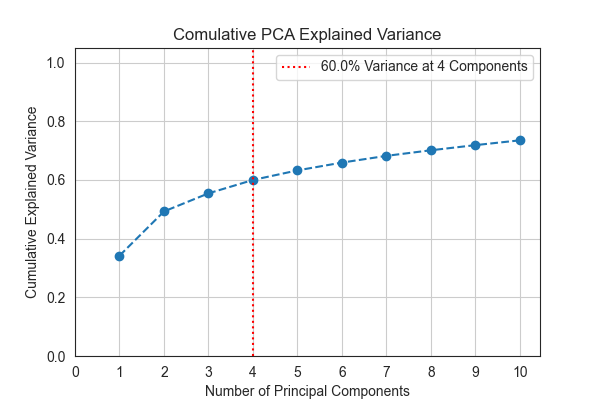

In [13]:
# 80% explained variance balances retaining most of the data's information with a significant reduction in complexity.

calc_plot_pca_value(X_scaled, target_variance=0.6, n_components=10)

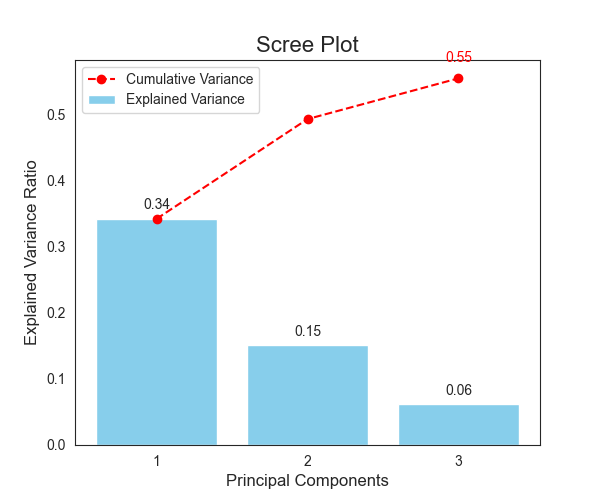

In [14]:
scree_plot_for_selected_pca_value(X_scaled, n_components=3)

In [15]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

loadings = pd.DataFrame(
    pca.components_.T,  # transpose so features are rows
    index=feature_names,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)],
)

pc_information = set()

for pc in loadings.columns:

    positive_corr = loadings.sort_values(pc, ascending=False).index[:10].tolist()
    negative_corr = loadings.sort_values(pc, ascending=True).index[:10].tolist()

    pc_information.update(positive_corr + negative_corr)

print(f"number of informative features: {len(pc_information)}")

number of informative features: 54


In [16]:
# reduce dimensionality based on most informative features:
selected_features = fitted_df[list(pc_information)]
selected_features.shape

(137375, 54)

### Kmeans

In [17]:
# scaling for the selected features with most information (variance)
scaler = MinMaxScaler()
X_selected_scaled = scaler.fit_transform(selected_features)

pca = PCA(n_components=3)
X_pca_selected = pca.fit_transform(X_selected_scaled)

silhouette for k 2 done
silhouette for k 3 done
silhouette for k 4 done
silhouette for k 5 done
silhouette for k 6 done
silhouette for k 7 done
silhouette for k 8 done
silhouette for k 9 done


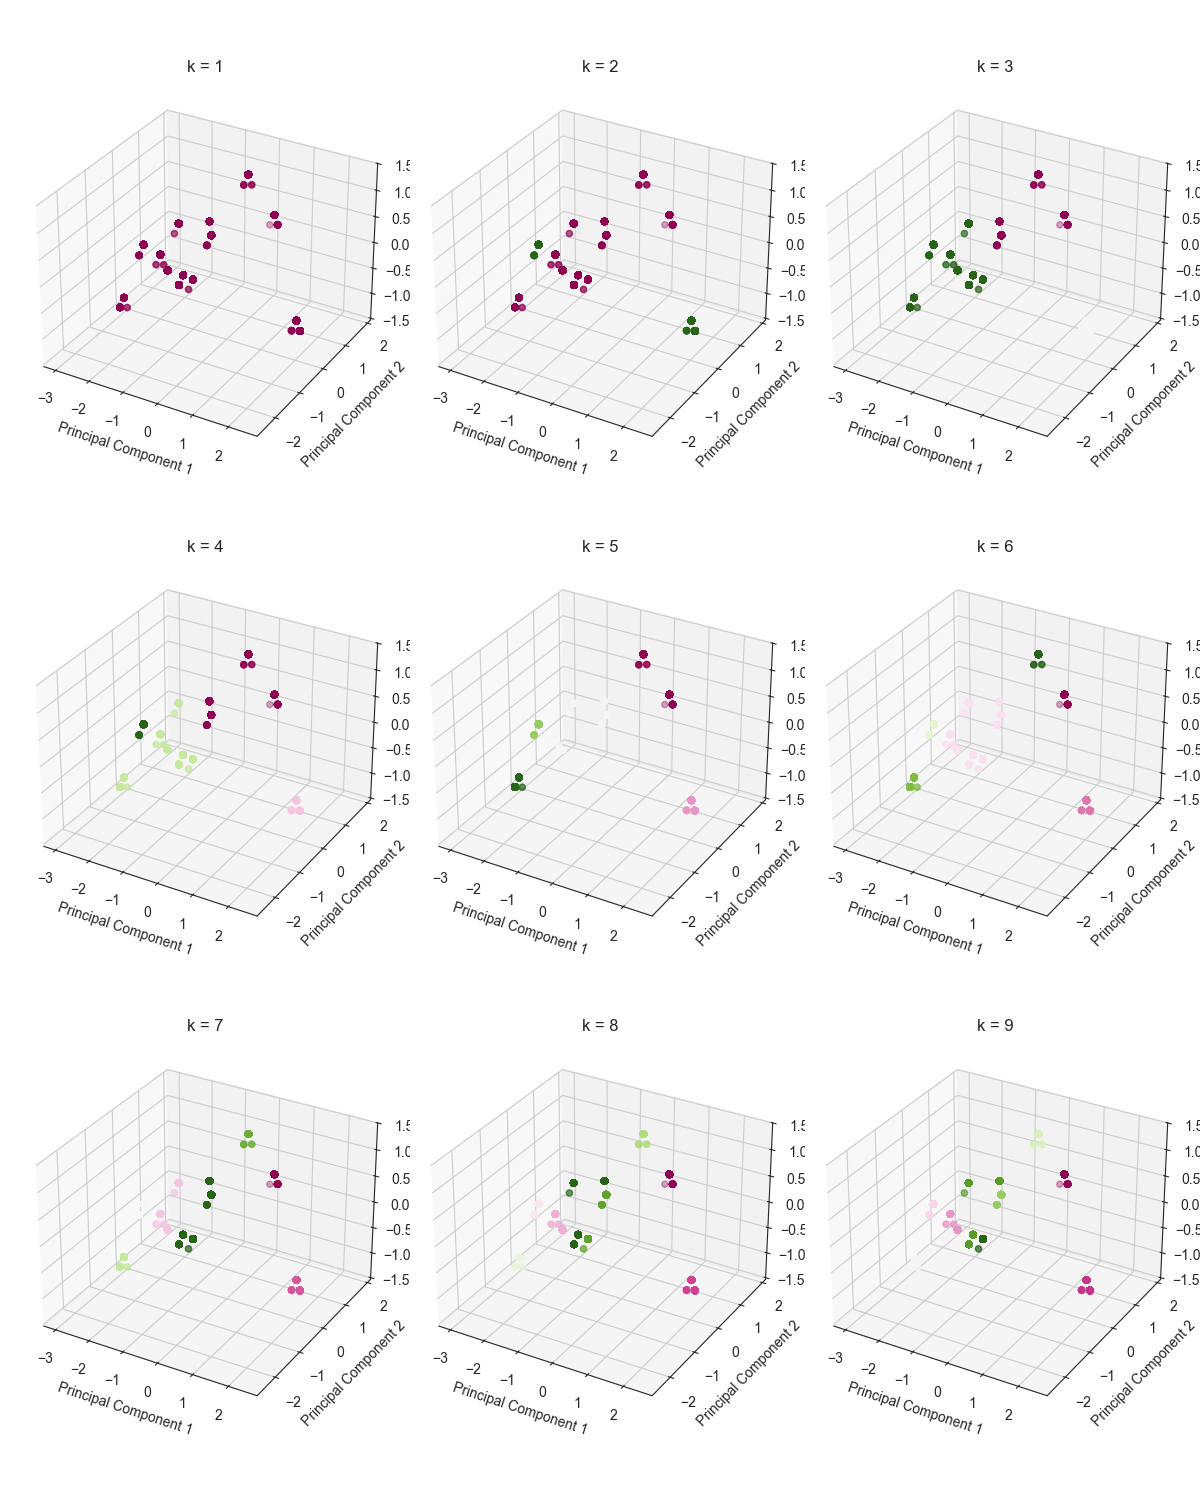

In [19]:
k_values, wcss, sil_scores = test_k(1, 10, X_pca_selected)

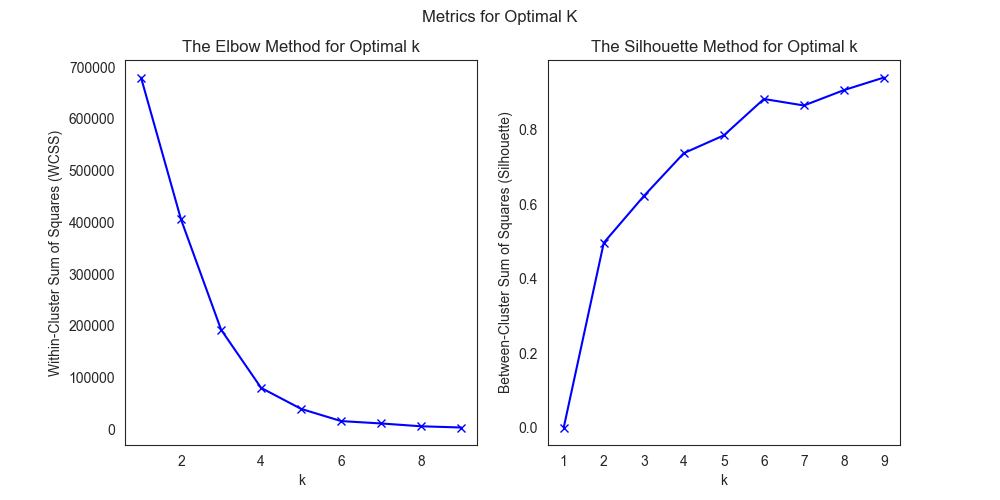

In [20]:
plot_kmeans_scores(k_values, wcss, sil_scores)

In [21]:
loadings = pd.DataFrame(
    pca.components_.T,  # transpose so features are rows
    index=selected_features.columns,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)],
)


# PC1: most (negatively) influenced from employment, most positively influenced from district B2, howsing, poverty, income
# high employment negative criminality?
# PC2: positively influeenced by employment, district B3, education, district C11

In [22]:
# convert variable names:
dpt = "11-00091"
DPT_ACS_PATH = os.path.join(DATA_BASEPATH, f"Dept_{dpt}", f"{dpt}_ACS_data")

# list all the acs folders
dpt_acs_files = [file for file in os.listdir(DPT_ACS_PATH) if "ACS" in file]

metadata_dfs = {}
# create a df for each csv of every category
demographics = [
    "education-attainment",
    "education-attainment-over-25",
    "employment",
    "income",
    "owner-occupied-housing",
    "poverty",
    "race-sex-age",
]
for category in demographics:
    for folder in dpt_acs_files:
        if folder.endswith(category):
            cat_folder = os.path.join(DPT_ACS_PATH, folder)

            # collect data and metadata csv
            for i in ["ann", "metadata"]:
                csv_name = [csv for csv in os.listdir(cat_folder) if i in csv][0]
                csv_path = os.path.join(cat_folder, csv_name)

                if i == "metadata":
                    col_names = ["code", "description"]
                    df = pd.read_csv(csv_path, header=None, names=col_names)
                    metadata_dfs[category] = df

In [23]:
new_var_names = []
for i in loadings.index:
    parts = i.rsplit("_", 1)
    var_code = parts[0]
    cat = parts[1]

    if cat in demographics:

        df = metadata_dfs[cat]
        description = df["description"].loc[df["code"] == var_code].values[0]

        new_var_names.append(f"{description}_{cat}")

    else:
        new_var_names.append(i)

print(f"number of new names {len(new_var_names)}")
description
loadings.index = new_var_names

number of new names 54


In [24]:
loadings.sort_values("PC3", ascending=True).head(30)

# pc1:  labor force variables - negative - employment, location district 1, district b2, high poverty, income black, high poverty, unemployment, unemployment, b2, employment asian
# pc2: district b3, high education, employment, older generations, black income asian, young employment, district c11. negative = new owner occupied, high education male, black, poverty, asian population, asian income, b2 district
# pc3:employment, working mothers, district c11, asian income, yemployment district d4, poverty,  negative: district b2, a1, black income, latino income

,PC1,PC2,PC3
one_hot__LOCATION_DISTRICT_B2,0.223336,-0.082403,-0.229715
one_hot__OFFICER_ASSIGNMENT.1_A1,-0.114530,-0.021719,-0.206267
one_hot__LOCATION_DISTRICT_A1,-0.112765,-0.026448,-0.199415
one_hot__OFFICER_ASSIGNMENT.1_B2,0.134210,-0.050446,-0.148334
Unemployment rate; Estimate; AGE - 45 to 54 years_employment,0.191355,0.079073,-0.130426
Labor Force Participation Rate; Estimate; RACE AND HISPANIC OR LATINO ORIGIN - Asian alone_employment,-0.168326,-0.021540,-0.122866
Unemployment rate; Estimate; EDUCATIONAL ATTAINMENT - Population 25 to 64 years - High school graduate (includes equivalency)_employment,0.124346,0.071326,-0.118776
Employment/Population Ratio; Estimate; Hispanic or Latino origin (of any race)_employment,-0.136811,0.038188,-0.092703
Percent below poverty level; Estimate; AGE - Under 18 years - Under 5 years_poverty,0.184526,0.018526,-0.087887
Unemployment rate; Estimate; RACE AND HISPANIC OR LATINO ORIGIN - Asian alone_employment,0.182170,-0.073410,-0.071652


number of labels: 137375; number of data_points : (137375, 3) 


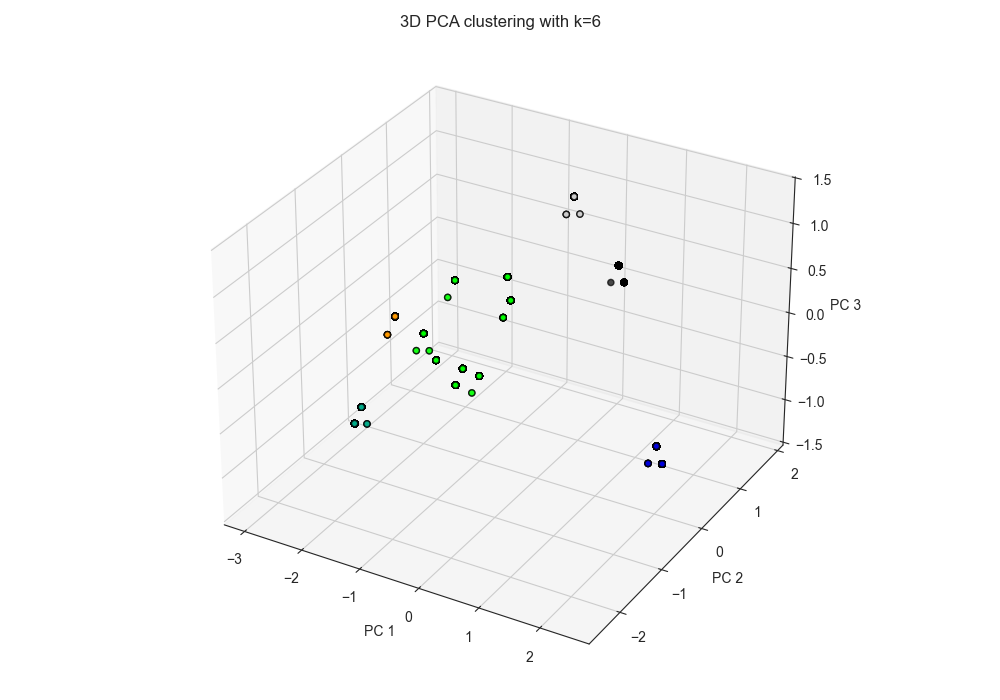

In [25]:
k = 6
kmeans = KMeans(n_clusters=k, random_state=60)
k_labels = kmeans.fit_predict(X_pca_selected)
print(
    f"number of labels: {len(k_labels)}; number of data_points : {X_pca_selected.shape} "
)
plot_pca_3d(X_pca_selected, k_labels, title=f'3D PCA clustering with k={k}')

### DBSCAN

In [19]:
pca_db = PCA(n_components=2)
X_pca_db = pca.fit_transform(X_scaled)


Text(0.5, 1.0, '"eps" range by changes in distances between clusters')

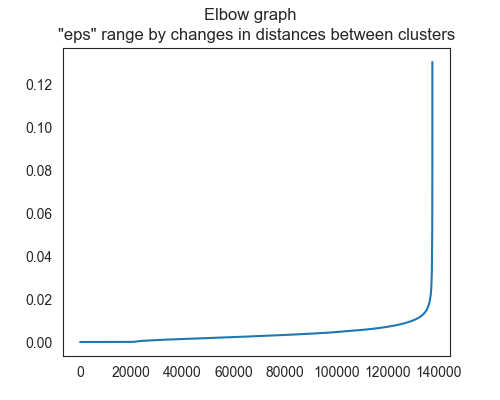

In [20]:
nn = NearestNeighbors(n_neighbors=20).fit(X_pca_db)
distances, indices = nn.kneighbors(X_pca_db)
distances = np.sort(distances, axis=0)
distances = distances[:,1]

# elbow point will give samller range for optimal eps value: b
plt.figure(figsize=(5,4))
plt.plot(distances)
plt.suptitle('Elbow graph')
plt.title('"eps" range by changes in distances between clusters')



Text(0.5, 1.0, '"eps" range by changes in distances between clusters')

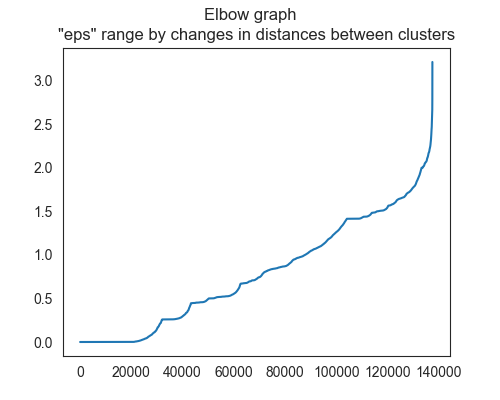

In [21]:
nn = NearestNeighbors(n_neighbors=20).fit(X_scaled)
distances, indices = nn.kneighbors(X_scaled)
distances = np.sort(distances, axis=0)
distances = distances[:,1]

# elbow point will give samller range for optimal eps value: b
plt.figure(figsize=(5,4))
plt.plot(distances)
plt.suptitle('Elbow graph')
plt.title('"eps" range by changes in distances between clusters')

In [22]:
# based on the elbow score, consider eps values between 1.5-2.5

min_samples = range(50, 110, 10)
eps = np.arange(0.01,0.03, 0.005)

output = []

for ms in min_samples:
    print(f'calculating for ms {ms}')
    for ep in eps:
        print(f'calculating for eps {ep}')
        labels = DBSCAN(min_samples=ms, eps = ep).fit(X_pca_db).labels_
        print('caclulating silhouette score')
        score = silhouette_score(X_pca_db, labels)
        output.append((ms, ep, score))

In [35]:
min_samples, eps, score = sorted(output, key=lambda x:x[-1])[-1]
print(f"Best silhouette_score: {score:.2f}")
print(f"min_samples: {min_samples}")
print(f"eps: {eps:.2f}")

Best silhouette_score: 0.35
min_samples: 50
eps: 2.30


<Axes: >

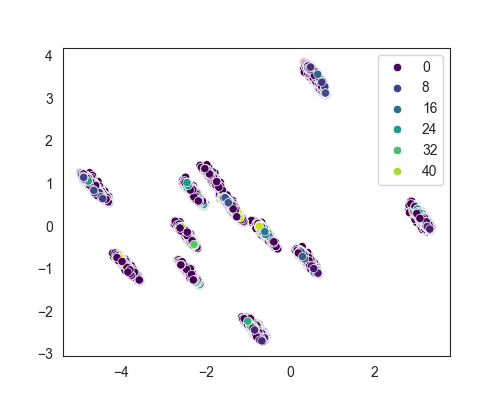

In [ ]:
# plot for 2 PCs
plt.figure(figsize=(5,4))
sns.scatterplot(x=X_pca_db[:,0], y=X_pca_db[:,1], hue=labels, palette='viridis')



In [ ]:
min_samples = range(50, 100, 10)
eps = np.arange(1.5, 2.5, 0.2)

output = []

for ms in min_samples:
    print(f'calculating for ms {ms}')
    for ep in eps:
        print(f'calculating for eps {ep}')
        labels = DBSCAN(min_samples=ms, eps = ep).fit(X_scaled).labels_
        print('caclulating silhouette score')
        score = silhouette_score(X_scaled, labels)
        output.append((ms, ep, score, labels))

min_samples, eps, score, labels = sorted(output, key=lambda x:x[-1])[-1]
print(f"Best silhouette_score: {score}")
print(f"min_samples: {min_samples}")
print(f"eps: {eps}")

calculating for ms 50
calculating for eps 1.5
caclulating silhouette score
calculating for eps 1.7
caclulating silhouette score
calculating for eps 1.9
caclulating silhouette score
calculating for eps 2.0999999999999996
caclulating silhouette score
calculating for eps 2.3
caclulating silhouette score
calculating for ms 60
calculating for eps 1.5
caclulating silhouette score
calculating for eps 1.7
caclulating silhouette score
calculating for eps 1.9
caclulating silhouette score
calculating for eps 2.0999999999999996
caclulating silhouette score
calculating for eps 2.3
caclulating silhouette score
calculating for ms 70
calculating for eps 1.5
caclulating silhouette score
calculating for eps 1.7
caclulating silhouette score
calculating for eps 1.9
caclulating silhouette score
calculating for eps 2.0999999999999996
caclulating silhouette score
calculating for eps 2.3
caclulating silhouette score
calculating for ms 80
calculating for eps 1.5
caclulating silhouette score
calculating for eps

In [28]:
# pca for visualization: 
pca_scaled = PCA(n_components=2)
X_pca_scaled = pca_scaled.fit_transform(X_scaled)



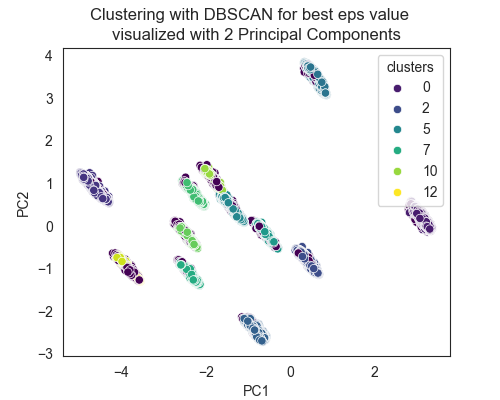

In [31]:
plt.figure(figsize=(5,4))
sns.scatterplot(x=X_pca_scaled[:,0], y=X_pca_scaled[:,1], hue=labels, palette='viridis')
plt.title('visualized with 2 Principal Components')
plt.suptitle('Clustering with DBSCAN for best eps value')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title='clusters')